# Imports

In [211]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import csv

from functions import *


from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Normalizer, StandardScaler, RobustScaler, MinMaxScaler, QuantileTransformer, PowerTransformer, LabelEncoder, OneHotEncoder
from sklearn.model_selection import *
from sklearn.metrics import *

from matplotlib.patches import Patch
from matplotlib.lines import Line2D



%matplotlib notebook
%matplotlib inline
    
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load features

- load_train_meta(vals = False)
- load_features(vals = False)

In [3]:
n = 0

Xmeta = load_train_meta()
Xwave = load_wave_features()

print("Shape of Xmeta:", Xmeta.shape)
print("Shape of Xwave", Xwave.shape)

Shape of Xmeta: (1100, 5)
Shape of Xwave (1100, 30)


## Data Exploration

In [4]:
D = Xmeta['direction']
G = Xmeta['group']
S = Xmeta['speed']
L = Xmeta['label']

- plot_sorted_counts(data, label, xtick=True, rot=90, sorted=True, coloring=None)



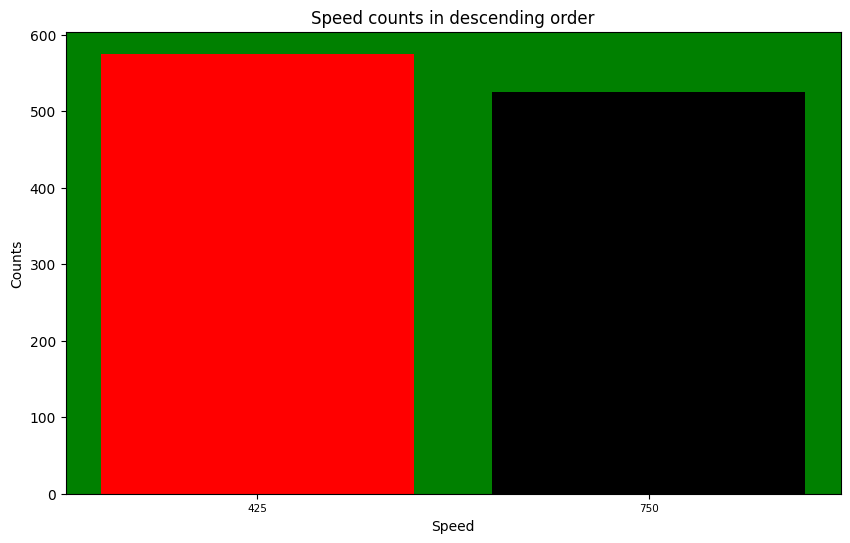

In [5]:
plot_sorted_counts(S, 'Speed', rot = 0)

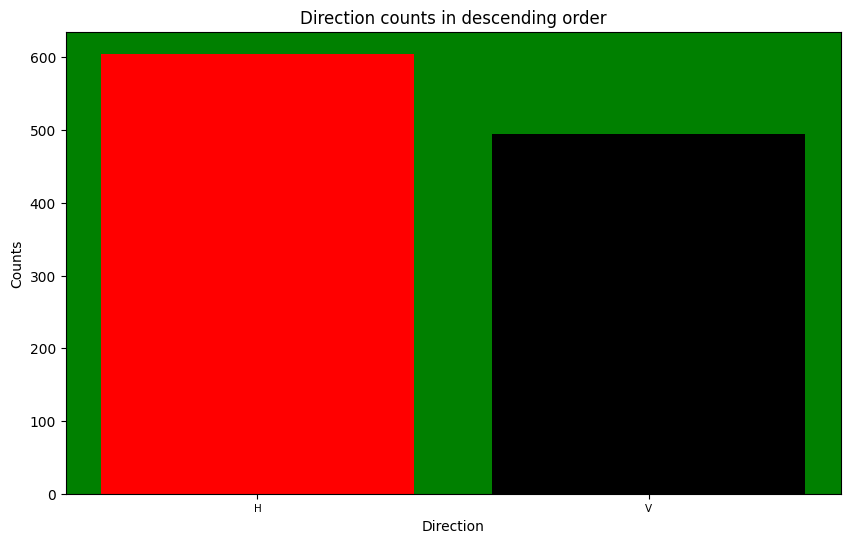

In [6]:
plot_sorted_counts(D, 'Direction', rot = 0)

['DAQ_1' 'DAQ_10' 'DAQ_11' 'DAQ_2' 'DAQ_3' 'DAQ_4' 'DAQ_5' 'DAQ_6' 'DAQ_7'
 'DAQ_8' 'DAQ_9'] [110 100  95 130  95  85 115 100  95 105  70]


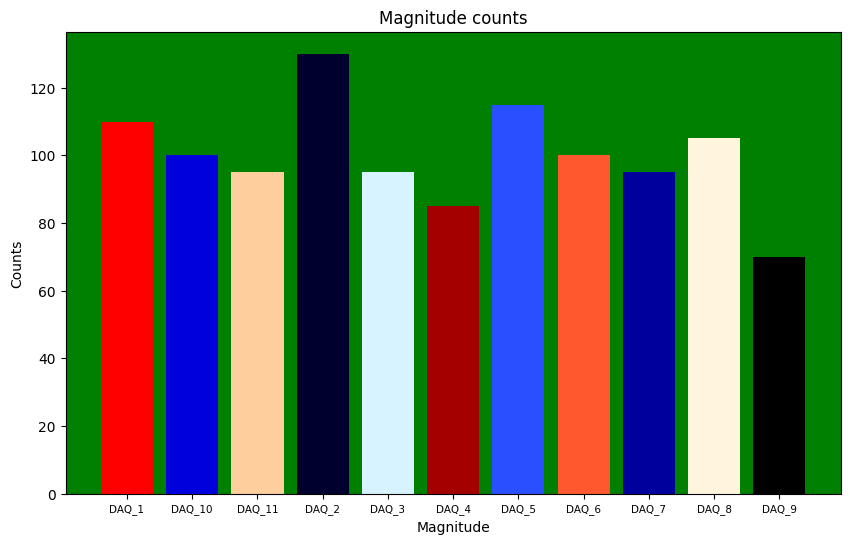

In [56]:
plot_sorted_counts(G, 'Magnitude', rot = 0, sorted=False)

In [8]:
newCols = pd.DataFrame()
newCols['OneHotDirGroup'] = Xmeta['direction'] + '_' + Xmeta['group'].str.split('_').str[1]

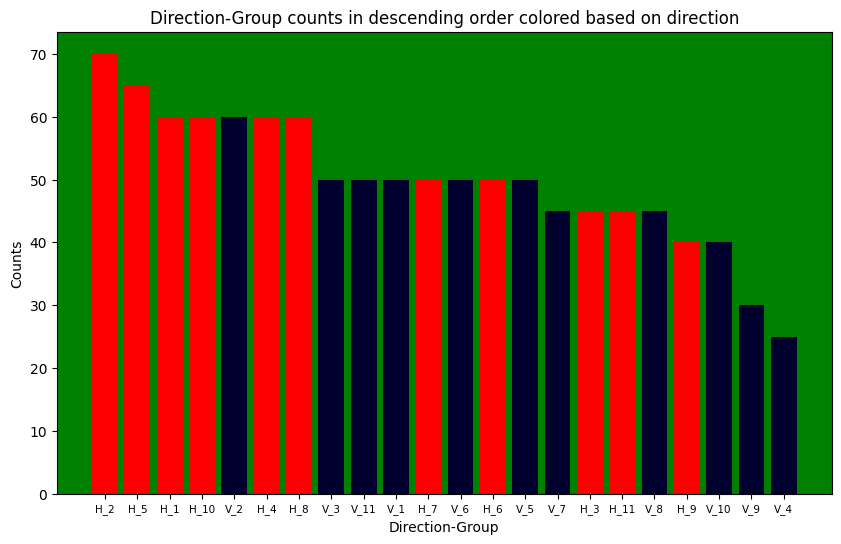

In [9]:
plot_sorted_counts(newCols['OneHotDirGroup'], 'Direction-Group', rot = 0, coloring = 'dir')

In [10]:
newCols['OneHotDirSpeed'] = Xmeta['direction'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

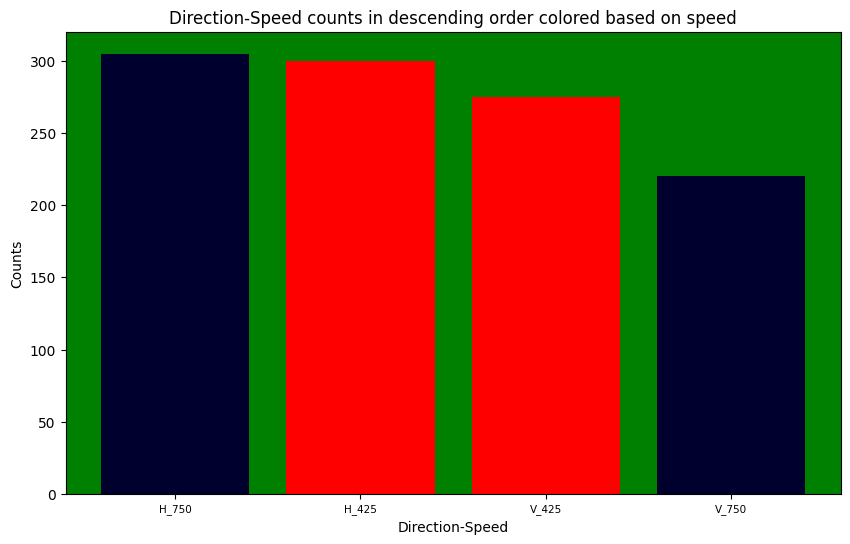

In [11]:
plot_sorted_counts(newCols['OneHotDirSpeed'], 'Direction-Speed', rot = 0, coloring = 'spd')

In [12]:
newCols['OneHotEvr'] = newCols['OneHotDirGroup'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

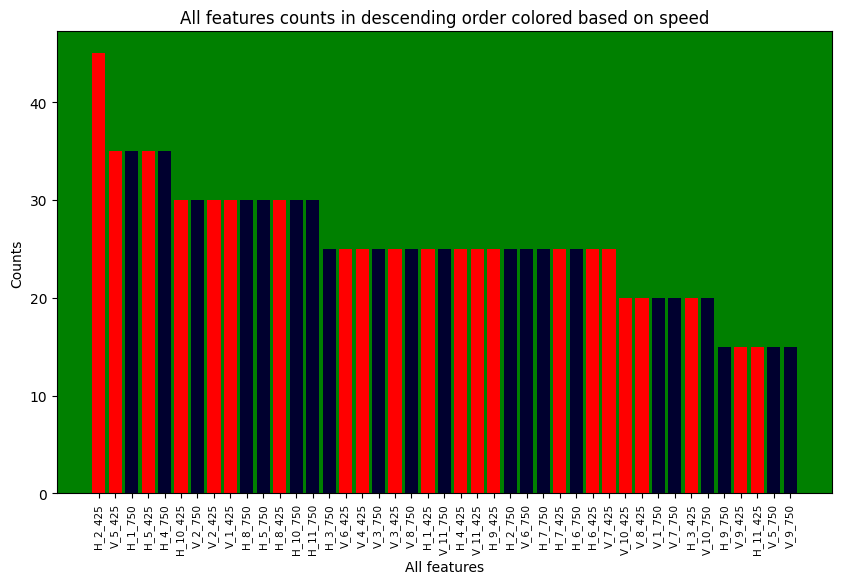

In [13]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'spd')

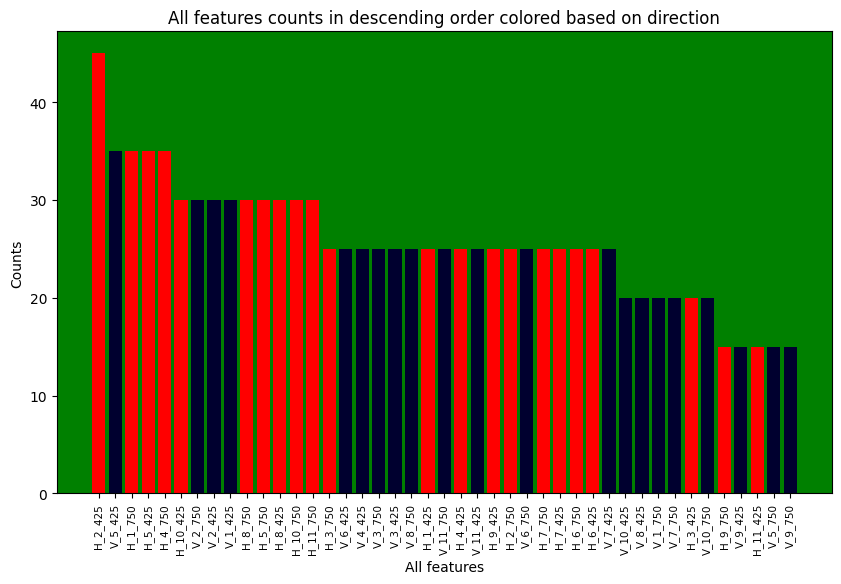

In [14]:
plot_sorted_counts(newCols['OneHotEvr'], 'All features', rot = 90, sorted = True, coloring = 'dir')

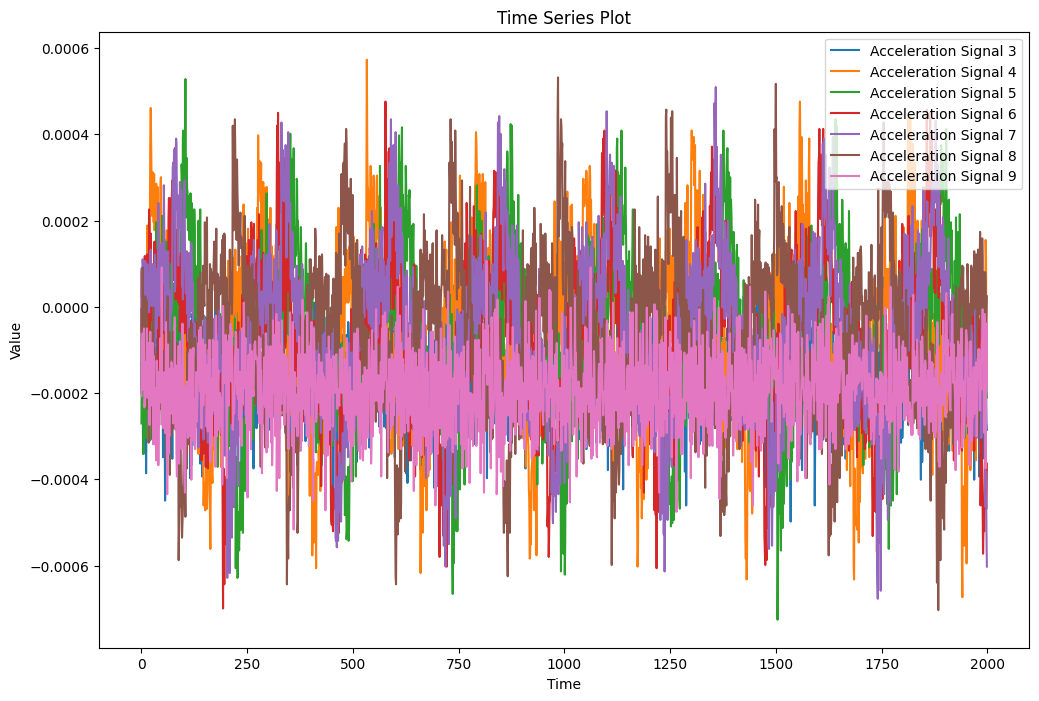

In [15]:
plot_series(3, 10, low = False, high = False, acc = True)

- store_wave_features(store = False)


In [16]:
f = store_wave_features()

Window 0
Window 150
Window 300
Window 450
Window 600
Window 750
Window 900
Window 1050
Window 0
Window 150
Window 300
Window 450
Window 600
Window 750
Window 900
Window 1050
Window 0
Window 150
Window 300
Window 450
Window 600
Window 750
Window 900
Window 1050


- get_correlations(X)

In [17]:
Xwave = load_wave_features()

# get_correlations(Xwave)

## Visualizing Compressed Features per wave

- analyze(X, features, title, labels, scaler=None)

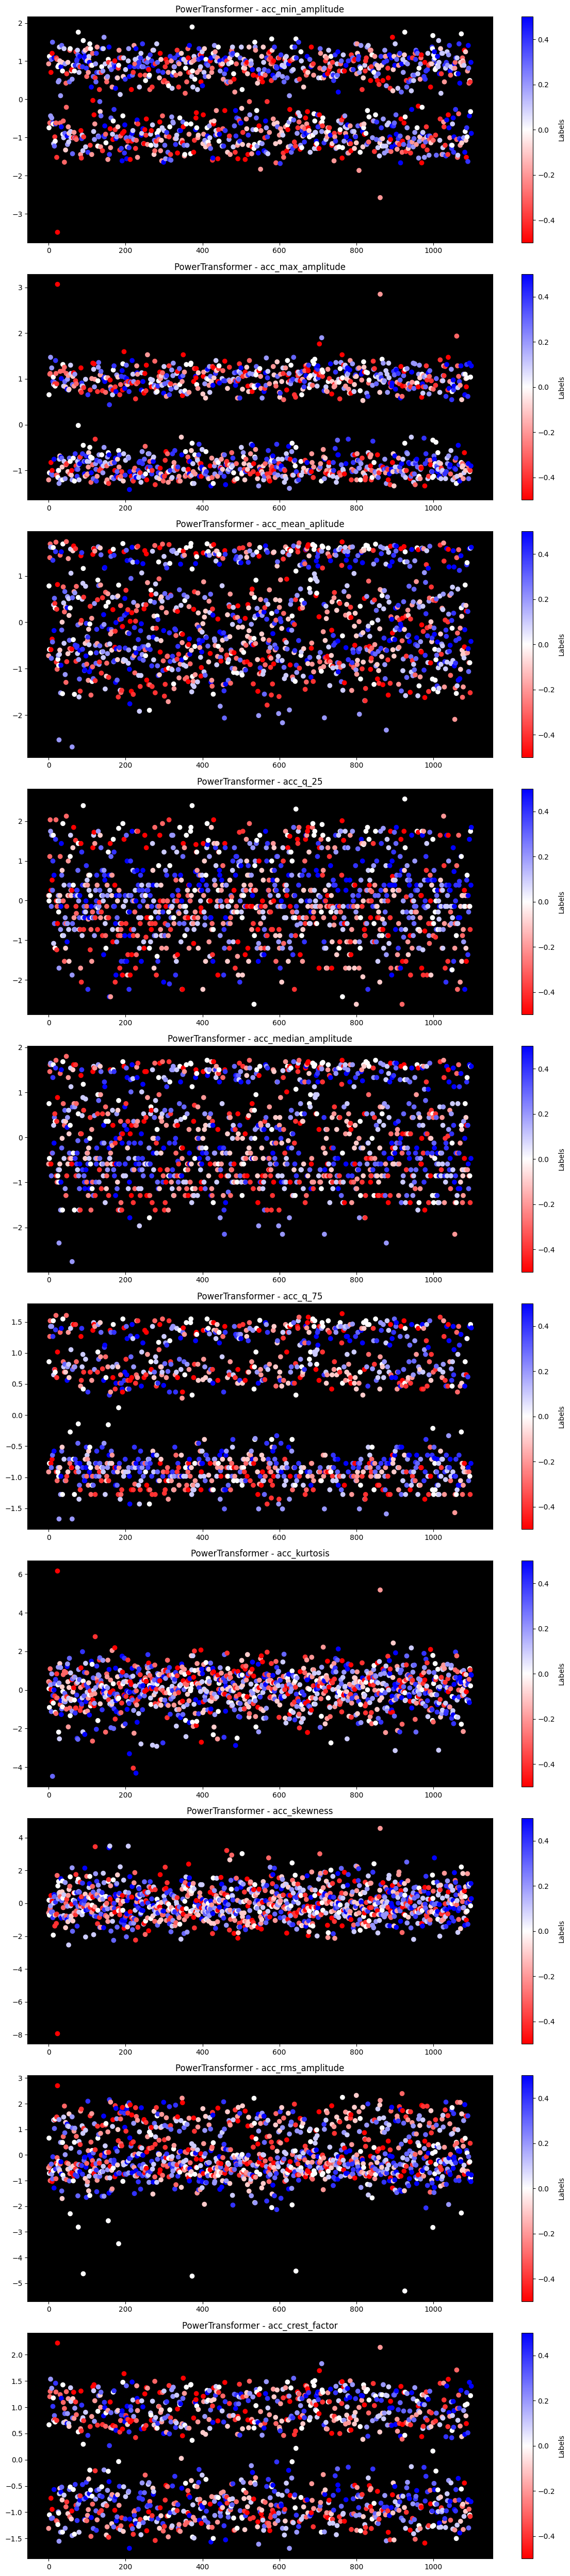

In [18]:
# List of preprocessing techinques

preprocessingList = [PowerTransformer()]


# Choose which wave and store features (low, high, acc)
wave = 'acc'
features = []

for feature in Xwave.columns:
    if feature.startswith(wave):
        features += [feature]

# Visualize compressed features with preprocessing
for pre in preprocessingList:
    analyze(Xwave, features, str(pre)[:-2], Xmeta['label'], pre)


# Visualize compressed features without any preprocessing (original data)
# analyze(Xwave, features, 'Original', Xmeta['label'])

# Cross Validation

In [19]:
n_folds = 4

DS = Xmeta['direction'] + '_' + Xmeta['speed'].apply(lambda x: '425' if x <= 500 else '750')

#StratifiedKFold
cv = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state = 2211595)

#KFold
# cv = KFold(n_splits=n_folds, shuffle=True, random_state = 2211595)

# Training

In [20]:
Xtrain = Xwave
Ytrain = Xmeta['group']

print('Shape of Xtrain:', Xtrain.shape)
print('Shape of Ytrain:', Ytrain.shape)


Shape of Xtrain: (1100, 30)
Shape of Ytrain: (1100,)


In [21]:
preprocessing = Pipeline([
                        ('pre1', PowerTransformer()),
                         ]) 

feature_selection = Pipeline([('selectkbest', SelectKBest())]) 

classifier = Pipeline([('clf', LogisticRegression(max_iter=10_000_000))])

In [22]:
start = 38.25
end = 38.36
num = 10

values = np.linspace(start, end, num)

print("C values:", values)

param_grid = {
    'feature_selection__selectkbest__k' : [25, 26, 27,28],
    'classifier__clf__C' : values,
}

C values: [38.25       38.26222222 38.27444444 38.28666667 38.29888889 38.31111111
 38.32333333 38.33555556 38.34777778 38.36      ]


In [23]:
pipeline = Pipeline([
    ('preprocessing', preprocessing),
    ('feature_selection', feature_selection),
    ('classifier', classifier)])

gridsearch = GridSearchCV(pipeline, param_grid, n_jobs=4, cv=cv, verbose=5, return_train_score=True)
gridsearch.fit(Xtrain, Ytrain)

results = gridsearch.cv_results_

train_score = results['mean_train_score'][gridsearch.best_index_]
validation_score = results['mean_test_score'][gridsearch.best_index_]

print()

print('Best params:')
print(gridsearch.best_params_)

print()

print('Training accuracy {}'.format(train_score))
print('Validation accuracy: {}'.format(validation_score))

print()

gridsearch.best_estimator_

Fitting 4 folds for each of 40 candidates, totalling 160 fits

Best params:
{'classifier__clf__C': 38.28666666666667, 'feature_selection__selectkbest__k': 26}

Training accuracy 0.3621212121212121
Validation accuracy: 0.26545454545454544



Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('pre1', PowerTransformer())])),
                ('feature_selection',
                 Pipeline(steps=[('selectkbest', SelectKBest(k=26))])),
                ('classifier',
                 Pipeline(steps=[('clf',
                                  LogisticRegression(C=38.28666666666667,
                                                     max_iter=10000000))]))])

In [ ]:
# Print results
# results

# Error Analysis

In [29]:
model = gridsearch.best_estimator_

In [30]:
def plot_learning_curve(sizes, train, val):
    
    train_scores_mean = np.mean(train, axis=1)
    train_scores_std = np.std(train, axis=1)
    val_scores_mean = np.mean(val, axis=1)
    val_scores_std = np.std(val, axis=1)

    _, axes = plt.subplots(1,)
    axes.grid()
    
    axes.fill_between(
        sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="g",
    )
    
    axes.fill_between(
        sizes,
        val_scores_mean - val_scores_std,
        val_scores_mean + val_scores_std,
        alpha=0.1,
        color="r",
    )
    
    axes.plot(
        sizes, train_scores_mean, "o-", color="g", label="Training score"
    )
    
    axes.plot(
        sizes, val_scores_mean, "o-", color="r", label="Cross-validation score"
    )
    
    axes.set_ylim((0,1))
    axes.legend(loc="best")
    
    plt.show()
    
    return

In [175]:
train_sizes, train_scores, val_scores = learning_curve(model, Xtrain, Ytrain, cv=cv, n_jobs=4, verbose=0)

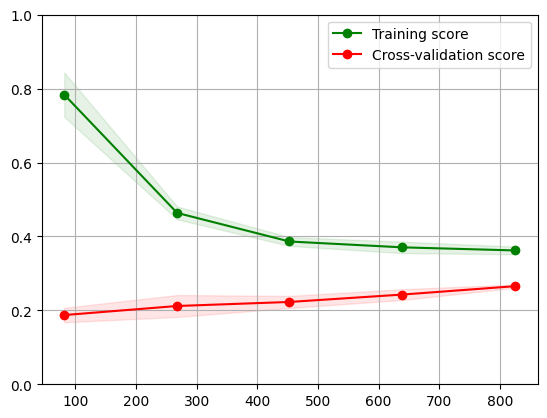

In [176]:
plot_learning_curve(train_sizes, train_scores, val_scores)

In [179]:
y_val = cross_val_predict(model, Xtrain, y=Ytrain, cv=cv, n_jobs=4, verbose=0)

In [185]:
p, r, F, sup = precision_recall_fscore_support(Ytrain, y_val)

validation_results = pd.DataFrame({'precision':p,'recall':r,'F1-score':F,'support':sup})

groups = pd.DataFrame({'group': ['DAQ_1', 'DAQ_10', 'DAQ_11', 'DAQ_2', 'DAQ_3', 'DAQ_4', 'DAQ_5', 'DAQ_6', 'DAQ_7', 'DAQ_8', 'DAQ_9']})

validation_results = pd.concat([validation_results, groups], axis = 1)

validation_results.set_index('group', inplace=True)
validation_results.sort_values(by='precision', inplace=True, ascending=False)


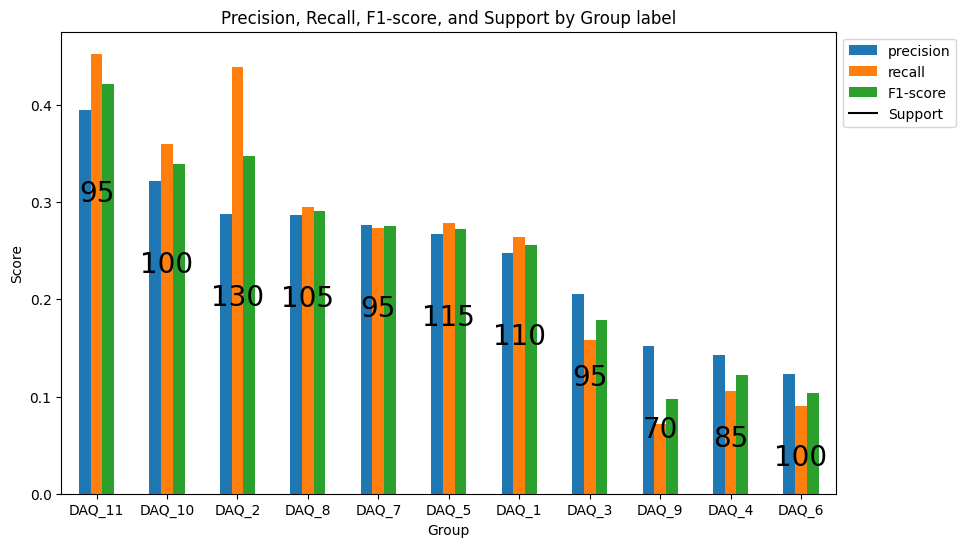

In [212]:
ax = validation_results[['precision', 'recall', 'F1-score']].plot.bar(figsize=(10, 6), rot=0)

for i, (index, row) in enumerate(validation_results.iterrows()):
    for j, value in enumerate(row[['precision', 'recall', 'F1-score']]):
        if j == 0:
            ax.text(i + j * 0.2, value - 0.1, f"{int(row['support'])}", ha='center', va='bottom', fontsize=20, color='k')

ax.set_xlabel('Group')
ax.set_ylabel('Score')
ax.set_title('Precision, Recall, F1-score, and Support by Group label')


handles, labels = ax.get_legend_handles_labels()
support_legend_entry = Line2D([0], [0], marker='', color='k', label='Support', markersize=10, linestyle='-')

handles.append(support_legend_entry)
labels.append('Support')

ax.legend(handles=handles, labels=labels, loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

<Axes: xlabel='precision', ylabel='recall'>

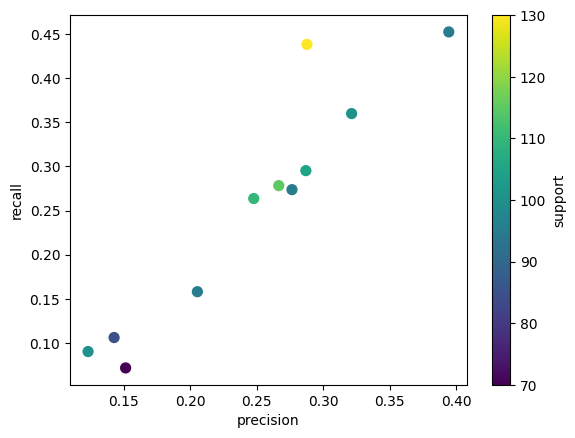

In [187]:
validation_results.plot.scatter(x='precision', y='recall', c='support', colormap='viridis', s=50)

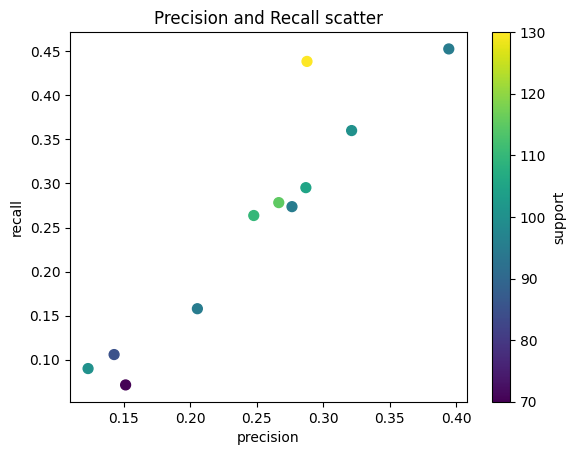

In [216]:
validation_results.plot.scatter(x='precision', y='recall', c='support', colormap='viridis', s=50)

plt.title('Precision and Recall scatter')
plt.show()

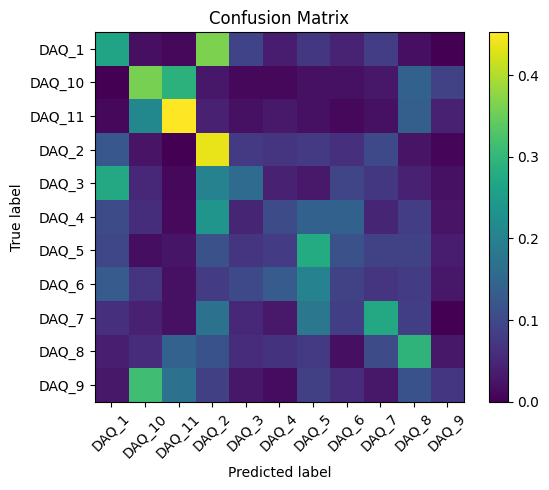

In [217]:
ConfusionMatrixDisplay.from_predictions(Ytrain, y_val, include_values=False,normalize='true', xticks_rotation=45)

plt.title('Confusion Matrix')
plt.show()

In [4]:
error_analysis()

NameError: name 'error_analysis' is not defined